In [7]:
import numpy as np
import pandas as pd
import csv
from scipy import stats
import os
import datetime
import statsmodels.api as sm
import requests
import sys, json
import time
import random
import json
import re
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

pd.set_option("display.max_columns", 30)

# Whiskey Analysis

### How can we use whiskey ratings and whiskey flavor profiles found for some of the more popular whiskeys to explore matrix factorization techniques?

In [8]:
# DATA PREP. READ IN FILE

df_main_full = pd.read_csv('../Datasets/whiskeys_full_df_v2.csv', index_col = False)
df_main_full.head()
# df_main_full.shape

,Whisk_Name,Whisk_Type,Whisk_Loc,Communal_Rating,Distiller_Score,URL,Num_Revs,Brand,Cost,Age,ABV,Flavor,Profile,smoky,peaty,spicy,herbal,oily,full_bodied,rich,sweet,briny,salty,vanilla,tart,fruity,floral,Distiller
0,TULLIBARDINE THE MURRAY MARSALA FINISH,Single Malt,HIGHLAND,4.19,86.0,https://distiller.com/spirits/tullibardine-the...,8,TULLIBARDINE,3,NAS,46.0,SWEET,"{""smoky"":0,""peaty"":0,""spicy"":15,""herbal"":10,""o...",0.0,0.0,15.0,10.0,40.0,35.0,40.0,45.0,0.0,0.0,20.0,20.0,35.0,10.0,TULLIBARDINE
1,GLENGLASSAUGH 30 YEAR,Single Malt,HIGHLAND,4.38,NaN,https://distiller.com/spirits/glenglassaugh-30...,9,GLENGLASSAUGH,5,30,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GLENGLASSAUGH
2,LEDAIG 13 AMONTILLADO CASK FINISH,Single Malt,ISLANDS,3.84,NaN,https://distiller.com/spirits/ledaig-13-amonti...,9,NaN,4,13,59.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OTHER
3,KILCHOMAN BOURBON SINGLE CASK,Single Malt,ISLAY,3.03,NaN,https://distiller.com/spirits/kilchoman-bourbo...,9,NaN,4,NAS,59.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KILCHOMAN
4,DEANSTON 12 YEAR SHERRY OAK,Single Malt,HIGHLAND,3.34,NaN,https://distiller.com/spirits/deanston-12-year...,8,NaN,2,12,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DEANSTON


Let's get rid of the records where Distiller_Score is missing. <br>
These will also not have any flavor profiles associated with them either, which we need for matrix factorization.

In [9]:
# GET FILTER DOWN TO COLUMNS AND ROWS

# Need there to exist whisky profile (when we do not have ratings)
df_main = df_main_full[df_main_full['Profile'].notnull()].reset_index(drop = True)

# Other columns we don't need because yes
cols_want = ['Whisk_Name', 'Whisk_Type', 'Whisk_Loc', 'Distiller', 'Num_Revs', 'Cost', 'Age', 'ABV', \
             'smoky', 'peaty', 'spicy', 'herbal', 'oily', 'full_bodied', 'rich', 'sweet', \
             'briny', 'salty', 'vanilla', 'tart', 'fruity', 'floral', 'Communal_Rating', 'Distiller_Score']
df_main = df_main[cols_want]
df_main.head()
df_main.shape

(792, 24)

In [7]:
df_main[df_main['Whisk_Name'] == 'THE BALVENIE DOUBLEWOOD 12 YEAR']

,Whisk_Name,Whisk_Type,Whisk_Loc,Distiller,Num_Revs,Cost,Age,ABV,smoky,peaty,spicy,herbal,oily,full_bodied,rich,sweet,briny,salty,vanilla,tart,fruity,floral,Communal_Rating,Distiller_Score
380,THE BALVENIE DOUBLEWOOD 12 YEAR,Single Malt,SPEYSIDE,BALVENIE,5494,3,12,40.0,30.0,0.0,30.0,10.0,20.0,70.0,70.0,70.0,10.0,10.0,70.0,40.0,70.0,30.0,3.87,87.0


### Preprocess and clean up the dataframe

What else is NA? How do we want to fill?

In [8]:
df_main.isnull().sum()

Whisk_Name         0
Whisk_Type         0
Whisk_Loc          9
Distiller          0
Num_Revs           0
Cost               0
Age                0
ABV                0
smoky              0
peaty              0
spicy              0
herbal             0
oily               0
full_bodied        0
rich               0
sweet              0
briny              0
salty              0
vanilla            0
tart               0
fruity             0
floral             0
Communal_Rating    0
Distiller_Score    0
dtype: int64

In [9]:
df_main[df_main['Whisk_Loc'].isnull()]

,Whisk_Name,Whisk_Type,Whisk_Loc,Distiller,Num_Revs,Cost,Age,ABV,smoky,peaty,spicy,herbal,oily,full_bodied,rich,sweet,briny,salty,vanilla,tart,fruity,floral,Communal_Rating,Distiller_Score
108,FORAGER'S KEEP 26 YEAR,Single Malt,NaN,ORPHAN BARREL WHISKY CO.,28,5,26,48.0,25.0,25.0,30.0,0.0,35.0,55.0,60.0,50.0,15.0,15.0,25.0,20.0,20.0,10.0,4.09,93.0
134,DARKNESS 8 YEAR SINGLE MALT,Single Malt,NaN,DARKNESS!,28,2,8,47.8,0.0,0.0,40.0,25.0,40.0,35.0,20.0,40.0,0.0,0.0,45.0,20.0,25.0,10.0,3.29,80.0
137,BUNNAHABHAIN 2003 PEDRO XIMENEZ FINISH,Single Malt,NaN,BUNNAHABHAIN,29,4,NAS,54.8,0.0,0.0,10.0,10.0,60.0,70.0,75.0,90.0,0.0,20.0,10.0,35.0,50.0,5.0,4.66,88.0
182,MORTLACH 15 YEAR (GAME OF THRONES SIX KINGDOMS),Single Malt,NaN,MORTLACH,64,4,15,46.0,10.0,0.0,45.0,20.0,55.0,60.0,65.0,60.0,20.0,5.0,50.0,15.0,25.0,25.0,3.98,90.0
262,ABERFELDY 16 YEAR,Single Malt,NaN,ABERFELDY,186,4,16,40.0,40.0,0.0,45.0,10.0,10.0,50.0,50.0,50.0,10.0,0.0,40.0,30.0,55.0,35.0,3.91,91.0
318,AERSTONE SEA CASK 10 YEAR,Single Malt,NaN,AERSTONE,104,2,10,40.0,30.0,10.0,60.0,70.0,40.0,50.0,60.0,70.0,80.0,60.0,70.0,20.0,30.0,10.0,3.52,85.0
567,JURA BROOKLYN,Peated Single Malt,NaN,JURA,36,3,NAS,42.0,30.0,30.0,10.0,15.0,10.0,65.0,65.0,70.0,15.0,10.0,20.0,0.0,25.0,0.0,3.27,72.0
612,PEAT'S BEAST SINGLE MALT,Peated Single Malt,NaN,PEAT'S BEAST,59,2,NAS,46.0,25.0,25.0,10.0,5.0,15.0,15.0,25.0,30.0,10.0,15.0,25.0,10.0,20.0,0.0,3.17,79.0
673,AERSTONE LAND CASK 10 YEAR,Peated Single Malt,NaN,AERSTONE,122,2,10,40.0,60.0,60.0,30.0,55.0,50.0,80.0,70.0,60.0,10.0,25.0,40.0,40.0,30.0,10.0,3.59,93.0


Fill with most popular whiskey location for that distiller if exists. Otherwise, maybe remove the record.

In [10]:
distiller_loc = df_main_full.groupby(['Whisk_Loc', 'Distiller']).size().reset_index(name='count')
idx = distiller_loc.groupby(['Distiller'])['count'].transform(max) == distiller_loc['count']
distiller_loc = distiller_loc[idx].drop(columns = ['count'])
df_main = pd.merge(df_main.drop(columns = ['Whisk_Loc']), distiller_loc, on = ['Distiller'], how="left")

# https://www.aerstonescotchwhisky.com/en/
df_main['Whisk_Loc'][df_main['Distiller'] == 'AERSTONE'] = 'LOWLANDS'

df_main[df_main['Whisk_Loc'].isnull()]

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Whisk_Name,Whisk_Type,Distiller,Num_Revs,Cost,Age,ABV,smoky,peaty,spicy,herbal,oily,full_bodied,rich,sweet,briny,salty,vanilla,tart,fruity,floral,Communal_Rating,Distiller_Score,Whisk_Loc
110,FORAGER'S KEEP 26 YEAR,Single Malt,ORPHAN BARREL WHISKY CO.,28,5,26,48.0,25.0,25.0,30.0,0.0,35.0,55.0,60.0,50.0,15.0,15.0,25.0,20.0,20.0,10.0,4.09,93.0,NaN
137,DARKNESS 8 YEAR SINGLE MALT,Single Malt,DARKNESS!,28,2,8,47.8,0.0,0.0,40.0,25.0,40.0,35.0,20.0,40.0,0.0,0.0,45.0,20.0,25.0,10.0,3.29,80.0,NaN
622,PEAT'S BEAST SINGLE MALT,Peated Single Malt,PEAT'S BEAST,59,2,NAS,46.0,25.0,25.0,10.0,5.0,15.0,15.0,25.0,30.0,10.0,15.0,25.0,10.0,20.0,0.0,3.17,79.0,NaN


In [12]:
# GET RID OF NA's
df_main = df_main.dropna(axis = 0)
print(df_main.shape[0], " rows remaining from 1500")
df_main.isnull().sum()

801  rows remaining from 1500


Whisk_Name         0
Whisk_Type         0
Distiller          0
Num_Revs           0
Cost               0
Age                0
ABV                0
smoky              0
peaty              0
spicy              0
herbal             0
oily               0
full_bodied        0
rich               0
sweet              0
briny              0
salty              0
vanilla            0
tart               0
fruity             0
floral             0
Communal_Rating    0
Distiller_Score    0
Whisk_Loc          0
dtype: int64

### Processing and transforming the age feature

Looks like lots NAS. Outside of that, majority of whiskeys are 10, 12, 15, 18, 21, 25 years old.

    Age  count  Age_Numer  Age_Prop
19    3      2        3.0     0.002
29    5      9        5.0     0.011
30    6      4        6.0     0.005
31    7      2        7.0     0.002
32    8     17        8.0     0.021
33    9      7        9.0     0.009
0    10     64       10.0     0.080
1    11      4       11.0     0.005
2    12     86       12.0     0.107
3    13      5       13.0     0.006
4    14     21       14.0     0.026
5    15     49       15.0     0.061
6    16     24       16.0     0.030
7    17     18       17.0     0.022
8    18     47       18.0     0.059
9    19      9       19.0     0.011
10   20      7       20.0     0.009
11   21     23       21.0     0.029
12   22      3       22.0     0.004
13   23      5       23.0     0.006
14   24      4       24.0     0.005
15   25     25       25.0     0.031
16   26      4       26.0     0.005
17   27      1       27.0     0.001
18   28      2       28.0     0.002
20   30      8       30.0     0.010
21   31      1       31.0   

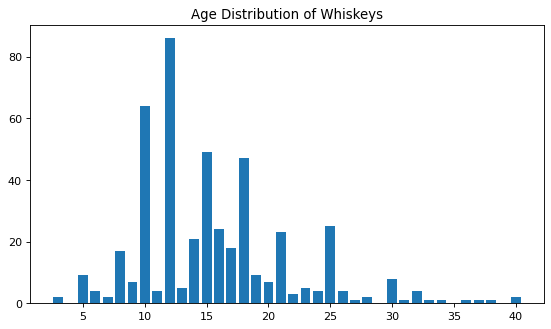

In [13]:
# HOW TO CLEAN THE AGE

age_cts = df_main.groupby(['Age']).size().reset_index(name='count')
age_cts['Age_Numer'] = pd.to_numeric(age_cts['Age'], errors='coerce')
age_cts['Age_Prop'] = np.round(age_cts['count']/sum(age_cts['count']), 3)

print(age_cts.sort_values(['Age_Numer']))
figure(figsize=(7, 4), dpi=80)
plt.bar(age_cts['Age_Numer'], age_cts['count'])
plt.tight_layout()
plt.title('Age Distribution of Whiskeys')
plt.show()

Consider creating a categorical age bucket -- 'new', 'classic', 'middle', 'old', 'rare', 'nas'

In [14]:
# CREATE CATEGEORICAL AGE BUCKET FOR ONE-HOT
# under 12... 12 to 14... 15 to 19... 20 to 24... 25 and over... NAS

# create a list of our conditions
df_main['Age_Numer'] = pd.to_numeric(df_main['Age'], errors='coerce')

conditions = [
    (df_main['Age_Numer'] < 12),
    (df_main['Age_Numer'] >= 12) & (df_main['Age_Numer'] < 15),
    (df_main['Age_Numer'] >= 15) & (df_main['Age_Numer'] < 20),
    (df_main['Age_Numer'] >= 20) & (df_main['Age_Numer'] < 25), 
    (df_main['Age_Numer'] >= 25), 
    (np.isnan(df_main['Age_Numer']))
    ]

# create a list of the values we want to assign for each condition
values = ['new', 'classic', 'middle', 'old', 'rare', 'nas']

# create a new column and use np.select to assign values to it using our lists as arguments
df_main['Age_Grp'] = np.select(conditions, values)

df_main.groupby('Age_Grp').size().reset_index(name = 'ct')

,Age_Grp,ct
0,classic,112
1,middle,147
2,nas,339
3,new,109
4,old,42
5,rare,52


### Make one-hots

We can't use "text" features like Whisk_Loc. So we convert them to one-hots (per Chapter 4) and drop the originals.

In [15]:
# ONE HOT ON AGE BUCKET, WHISK LOCATION, Whisk_Type. 
# Also, convert Num_Revs to a log version

df_age = pd.get_dummies(df_main['Age_Grp'])
df_loc = pd.get_dummies(df_main['Whisk_Loc'])
# df_type = pd.get_dummies(df_main['Whisk_Type'])

df_main = pd.concat([df_main, df_age, df_loc], axis = 1)
df_main['Num_Rev_Log'] = np.round(np.log(df_main['Num_Revs']), 2)

In [17]:
df_final = df_main.drop(columns = ['Whisk_Name', 'Distiller', 'Age', 'Age_Numer', 'Age_Grp', \
                                   'Whisk_Loc', 'Whisk_Type', 'Num_Revs'])
pd.set_option('max_columns', None)
df_final.head()
df_final.describe(percentiles = [0.05, 0.25, 0.50, 0.75, 0.95])

,Cost,ABV,smoky,peaty,spicy,herbal,oily,full_bodied,rich,sweet,briny,salty,vanilla,tart,fruity,floral,Communal_Rating,Distiller_Score,classic,middle,nas,new,old,rare,(BOTTLED IN) VIRGINIA,CAMPBELTOWN,HIGHLAND,HIGHLANDS,ISLANDS,ISLAY,LOWLANDS,SKYE,SPEYSIDE,Num_Rev_Log
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,3.516854,46.611036,27.946317,20.626717,40.855181,24.548065,31.263421,56.636704,56.761548,54.724095,16.821473,18.278402,40.958801,26.094881,50.538077,23.895131,3.890674,87.722846,0.139825,0.183521,0.423221,0.136080,0.052434,0.064919,0.001248,0.041199,0.002497,0.308365,0.097378,0.254682,0.032459,0.001248,0.260924,4.468002
std,1.014903,5.546539,23.244695,26.472377,20.109177,17.671884,18.926748,18.353381,19.477983,19.357880,20.971215,20.229957,19.904008,18.021750,22.623635,20.249543,0.416377,5.006305,0.347022,0.387335,0.494379,0.343088,0.223041,0.246537,0.035333,0.198873,0.049938,0.462107,0.296657,0.435954,0.177328,0.035333,0.439413,1.491176
min,1.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.360000,65.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.790000
5%,2.000000,40.000000,0.000000,0.000000,10.000000,0.000000,0.000000,25.000000,25.000000,20.000000,0.000000,0.000000,10.000000,0.000000,15.000000,0.000000,3.260000,79.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.300000
25%,3.000000,43.000000,10.000000,0.000000,25.000000,10.000000,20.000000,45.000000,40.000000,40.000000,0.000000,0.000000,25.000000,10.000000,30.000000,10.000000,3.610000,85.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.330000
50%,3.000000,46.000000,20.000000,10.000000,40.000000,20.000000,30.000000,60.000000,60.000000,60.000000,10.000000,10.000000,40.000000,25.000000,50.000000,20.000000,3.880000,88.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.300000
75%,4.000000,48.800000,40.000000,40.000000,60.000000,35.000000,40.000000,70.000000,70.000000,70.000000,25.000000,30.000000,60.000000,40.000000,70.000000,30.000000,4.190000,91.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,5.380000
95%,5.000000,58.400000,75.000000,75.000000,70.000000,60.000000,67.000000,83.000000,86.000000,80.000000,60.000000,60.000000,70.000000,60.000000,80.000000,65.000000,4.550000,95.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,7.290000
max,5.000000,63.500000,100.000000,100.000000,94.000000,90.000000,85.000000,100.000000,100.000000,100.000000,100.000000,90.000000,90.000000,90.000000,100.000000,90.000000,5.000000,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.280000


<br>

In [19]:
df_main.columns

Index(['Whisk_Name', 'Whisk_Type', 'Distiller', 'Num_Revs', 'Cost', 'Age',
       'ABV', 'smoky', 'peaty', 'spicy', 'herbal', 'oily', 'full_bodied',
       'rich', 'sweet', 'briny', 'salty', 'vanilla', 'tart', 'fruity',
       'floral', 'Communal_Rating', 'Distiller_Score', 'Whisk_Loc',
       'Age_Numer', 'Age_Grp', 'classic', 'middle', 'nas', 'new', 'old',
       'rare', '(BOTTLED IN) VIRGINIA', 'CAMPBELTOWN', 'HIGHLAND', 'HIGHLANDS',
       'ISLANDS', 'ISLAY', 'LOWLANDS', 'SKYE', 'SPEYSIDE', 'Num_Rev_Log'],
      dtype='object')

## PCA Exploration

PCA is an unsupervised dimension reductionality technique that tries to determine how closely the different features move. <br> 
For our Whiskeys dataset, it basically tries to identify which flavor profiles move together. <br>

If a whiskey tastes fruity, does it also taste briny? <br>
If a whiskey is rich, is it also sweet and vanilla? <br>
If any flavor pairs/triplets/etc. move together, we'll be able to see them represented through PCA. <br>

And suppose sweet whiskeys also tend to be fruity. Then, instead of the "sweet" and "fruity" flavor being separate dimensions, PCA would reduce these two dimensions into a new dimension called "sweet and fruity". 

**What are some initial guesses?** <br>

Smoky + peaty. Fruity + sweet. Salty + spicy.

### Pre-processing for PCA

PCA requires the data to be pre-centered. <br>
**Note:** Features do not need to be scaled to have the same variance. But usually they are especially if the variances between features are quite different.

In [20]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

age_mapper = {'new':1, 'classic':2, 'nas':3, 'middle':4, 'old':5, 'rare':6}
df_final['Age_Grp_2'] = df_main['Age_Grp'].replace(age_mapper)

stdard = StandardScaler()
robust = RobustScaler()
mms = MinMaxScaler()

cols_to_scale = ['smoky', 'peaty', 'spicy', 'herbal', 'oily', 'full_bodied', \
                 'rich', 'sweet', 'briny', 'salty', 'vanilla', 'tart', 'fruity', 'floral', \
                 'Communal_Rating', 'Distiller_Score', 'Num_Rev_Log']
df_final[cols_to_scale] = stdard.fit_transform(df_final[cols_to_scale])
df_final[['Cost', 'ABV']] = mms.fit_transform(df_final[['Cost', 'ABV']])

In [21]:
def describe_new(df):
    df1 = df.describe(percentiles = [0.05, 0.25, 0.50, 0.75, 0.95])
    df1.loc["range"] = df1.loc['max'] - df1.loc['min']
    return df1

describe_new(df_final)

,Cost,ABV,smoky,peaty,spicy,herbal,oily,full_bodied,rich,sweet,briny,salty,vanilla,tart,fruity,floral,Communal_Rating,Distiller_Score,classic,middle,nas,new,old,rare,(BOTTLED IN) VIRGINIA,CAMPBELTOWN,HIGHLAND,HIGHLANDS,ISLANDS,ISLAY,LOWLANDS,SKYE,SPEYSIDE,Num_Rev_Log,Age_Grp_2
count,801.000000,801.000000,8.010000e+02,8.010000e+02,8.010000e+02,8.010000e+02,8.010000e+02,8.010000e+02,8.010000e+02,8.010000e+02,8.010000e+02,8.010000e+02,8.010000e+02,8.010000e+02,8.010000e+02,8.010000e+02,8.010000e+02,8.010000e+02,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,8.010000e+02,801.000000
mean,0.629213,0.281321,-1.997293e-16,-1.363315e-15,-2.370139e-17,7.027254e-17,5.585766e-17,-5.613487e-18,1.124083e-16,5.322417e-17,-1.046465e-15,-4.934325e-17,-1.563460e-16,-2.973069e-16,2.125502e-16,1.325060e-16,6.885878e-16,-3.416604e-16,0.139825,0.183521,0.423221,0.136080,0.052434,0.064919,0.001248,0.041199,0.002497,0.308365,0.097378,0.254682,0.032459,0.001248,0.260924,4.947492e-16,3.071161
std,0.253726,0.236023,1.000625e+00,1.000625e+00,1.000625e+00,1.000625e+00,1.000625e+00,1.000625e+00,1.000625e+00,1.000625e+00,1.000625e+00,1.000625e+00,1.000625e+00,1.000625e+00,1.000625e+00,1.000625e+00,1.000625e+00,1.000625e+00,0.347022,0.387335,0.494379,0.343088,0.223041,0.246537,0.035333,0.198873,0.049938,0.462107,0.296657,0.435954,0.177328,0.035333,0.439413,1.000625e+00,1.287897
min,0.000000,0.000000,-1.203018e+00,-7.796657e-01,-2.032938e+00,-1.389971e+00,-1.652844e+00,-3.087828e+00,-2.915960e+00,-2.828734e+00,-8.026232e-01,-9.040960e-01,-2.059102e+00,-1.448871e+00,-2.235258e+00,-1.180770e+00,-3.678471e+00,-4.541682e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.797022e+00,1.000000
5%,0.250000,0.000000,-1.203018e+00,-7.796657e-01,-1.535342e+00,-1.389971e+00,-1.652844e+00,-1.724830e+00,-1.631657e+00,-1.794917e+00,-8.026232e-01,-9.040960e-01,-1.556377e+00,-1.448871e+00,-1.571820e+00,-1.180770e+00,-1.515617e+00,-1.743461e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.454796e+00,1.000000
25%,0.500000,0.127660,-7.725431e-01,-7.796657e-01,-7.889476e-01,-8.237466e-01,-5.954778e-01,-6.344321e-01,-8.610759e-01,-7.611006e-01,-8.026232e-01,-9.040960e-01,-8.022893e-01,-8.936389e-01,-9.083823e-01,-6.866235e-01,-6.745078e-01,-5.442233e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.636345e-01,2.000000
50%,0.500000,0.255319,-3.420687e-01,-4.016774e-01,-4.255347e-02,-2.575224e-01,-6.679490e-02,1.833666e-01,1.663661e-01,2.727159e-01,-3.254812e-01,-4.094707e-01,-4.820137e-02,-6.079129e-02,-2.379872e-02,-1.924767e-01,-2.565182e-02,5.539549e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.127348e-01,3.000000
75%,0.750000,0.374468,5.188803e-01,7.322874e-01,9.526387e-01,5.918138e-01,4.618880e-01,7.285658e-01,6.800870e-01,7.896241e-01,3.902319e-01,5.797799e-01,9.572492e-01,7.720563e-01,8.607849e-01,3.016702e-01,7.193310e-01,6.550143e-01,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,6.119782e-01,4.000000
95%,1.000000,0.782979,2.025541e+00,2.055246e+00,1.450235e+00,2.007374e+00,1.889332e+00,1.437325e+00,1.502041e+00,1.306532e+00,2.060229e+00,2.063656e+00,1.459974e+00,1.882520e+00,1.303077e+00,2.031184e+00,1.584472e+00,1.454506e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.893647e+00,6.000000
max,1.000000,1.000000,3.101727e+00,3.000217e+00,2.644465e+00,3.706047e+00,2.840961e+00,2.364163e+00,2.221250e+00,2.340349e+00,3.

### PCA on the Flavors

PCA uses a matrix factorization technique called Eigenvalue Decomposition (EVD). <br>
Each Eigenvector is also the Principal Component vector (PC). Eigenvalues tell us how much "data" there is in the direction of each PC. <br>

In [23]:
# PCA ON ONLY THE FLAVORS. INHERENT GROUPING OF WHISKEY FLAVORS?
df_flavors = df_final[['smoky', 'peaty', 'spicy', 'herbal', 'oily', 'full_bodied', \
                 'rich', 'sweet', 'briny', 'salty', 'vanilla', 'tart', 'fruity', 'floral']]

corr_mat = np.cov(df_flavors.T)
eigen_vals, eigen_vecs = np.linalg.eig(corr_mat)
print('\nEigenvalues \n%s' % sorted(np.round(eigen_vals, 3), reverse = True))
print('\nLargest eigenvector or Principal Component vector:\n', np.round(eigen_vecs[:,0], 3))


Eigenvalues 
[4.681, 2.987, 1.659, 0.834, 0.726, 0.626, 0.545, 0.48, 0.425, 0.328, 0.286, 0.155, 0.144, 0.141]

Largest eigenvector or Principal Component vector:
 [0.223 0.165 0.306 0.262 0.288 0.286 0.286 0.257 0.254 0.296 0.303 0.221
 0.287 0.269]


The bigger the eigenvalue, the more "important" the PC in describing the dataset. In fact, eigenvalues can tell us exactly how much variance in our data is explained in that direction by taking each eigenvalue and dividing it by the sum of all eigenvalues.

Cumulative Pct Variance Explained 
[0.334 0.547 0.665 0.725 0.777 0.821 0.86  0.894 0.925 0.948 0.969 0.98
 0.99  1.   ]


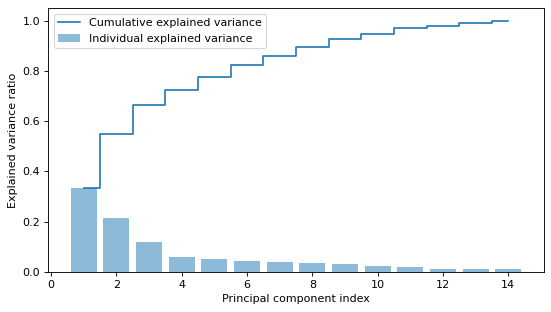

In [24]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print('Cumulative Pct Variance Explained \n%s' % np.round(cum_var_exp,3))

figure(figsize=(7, 4), dpi=80)
plt.bar(range(1, len(var_exp)+1), var_exp, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(1, len(var_exp)+1), cum_var_exp, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Making sense of the Principal Component vectors

We've looked at the eigenvalues. Now, let's take a closer look at the PCs (eigenvectors) and try to understand what they mean.

In [25]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [26]:
eig_flavor_mtx = np.hstack((eigen_pairs[0][1][:, np.newaxis],
                        eigen_pairs[1][1][:, np.newaxis],
                        eigen_pairs[2][1][:, np.newaxis], 
                        eigen_pairs[3][1][:, np.newaxis],
                        eigen_pairs[4][1][:, np.newaxis]))
eig_flavor_df = pd.DataFrame(np.round(eig_flavor_mtx, 3), columns = ['PC1','PC2','PC3','PC4','PC5'])
eig_flavor_df['flavor'] =  ['smoky', 'peaty', 'spicy', 'herbal', 'oily', 'full_bodied', 'rich', 'sweet', 'briny', 'salty', 'vanilla', 'tart', 'fruity', 'floral']
eig_flavor_df.set_index('flavor')

,PC1,PC2,PC3,PC4,PC5
flavor,,,,,
smoky,0.223,0.410,-0.102,-0.007,-0.356
peaty,0.165,0.461,-0.078,-0.024,-0.289
spicy,0.306,-0.072,0.176,0.314,-0.395
herbal,0.262,0.123,0.360,0.421,-0.116
oily,0.288,0.118,0.060,0.367,0.684
full_bodied,0.286,-0.126,-0.493,0.236,0.068
rich,0.286,-0.160,-0.479,0.245,-0.018
sweet,0.257,-0.302,-0.250,-0.248,-0.176
briny,0.254,0.382,-0.021,-0.305,0.221


### One interpretation of the eigenvectors.

**PC 1:** "A little bit of everything"  <br>

**PC 2:** "(Smoky + Peaty + Briny + Salty) do not go with (Fruity + Sweet)"

**PC 3:** "(Tart + Herbal) do not go well with (Full-bodied + Rich)"

**PC 4:** "(Herbal + Oily) and not (Briny + Salty), and vice-versa"

**PC 5:** "Very Oily and not Spicy (or that Smoky)"

Each Principal Component vector can be thought of as a new coordinate direction. <br>
A special property of the Principal Component vectors is that they are also orthogonal to each other. <br>
(In 2-dimensions, orthogonal is commonly referred to as perpindicular.) 

To test this, let's take the dot product of any two eigenvectors and see what we get.

In [27]:
print(np.dot(eig_flavor_mtx[:,0], eig_flavor_mtx[:,1]))
print(np.dot(eig_flavor_mtx[:,0], eig_flavor_mtx[:,2]))
print(np.dot(eig_flavor_mtx[:,3], eig_flavor_mtx[:,4]))

2.498001805406602e-16
1.942890293094024e-16
-7.632783294297951e-17


<br>

### Plotting our data on the Principal Components

Distiller.com likes to break out whiskeys into two main types -- **"Single Malt" and "Peated Single Malt".**

In [28]:
for l, c in zip(np.unique(df_main['Whisk_Type']), ['r', 'b']):
    print(l, c)
print(np.unique(df_main['Whisk_Type']))

Peated Single Malt r
Single Malt b
['Peated Single Malt' 'Single Malt']


Let's see if there Distiller.com "got it right" by looking at where these two main whiskey categories fall in a plot of our eigenvectors. <br>
To plot each whiskey onto the coordinate direction spanned by our Principal Components, simply take each data point (15 dimensions because 15 flavors) and take the dot product of that and our Principal Component (also 15 dimensions).

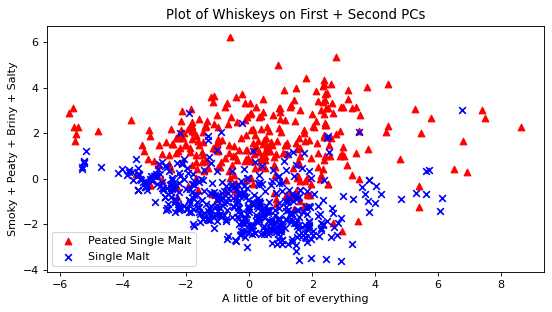

In [29]:
flavors_pca = df_flavors.dot(eig_flavor_mtx)

colors = ['r', 'b']
markers = ['^', 'x']

figure(figsize=(7, 4), dpi=80)
for l, c, m in zip(np.unique(df_main['Whisk_Type']), colors, markers):
    plt.scatter(flavors_pca.loc[df_main['Whisk_Type'] == l, 0], 
                flavors_pca.loc[df_main['Whisk_Type'] == l, 1], 
                c=c, label=l, marker=m)
plt.xlabel('A little of bit of everything')
plt.ylabel('Smoky + Peaty + Briny + Salty')
plt.legend(loc='lower left')
plt.title('Plot of Whiskeys on First + Second PCs')
plt.tight_layout()
plt.show()

Sometimes, the first Principal Component from PCA captures the general movement of all coordinates. <br>
Recall that our first PC is indeed like this ("a little bit of everything"). <br>
And both Single Malts and Peated Single Malts are somewhere on the range of having some of everything. <br>

As such, we like to plot our whiskeys on the 2nd and 3rd PCs to see if Single Malts and Peated Single Malts can be better differentiated.

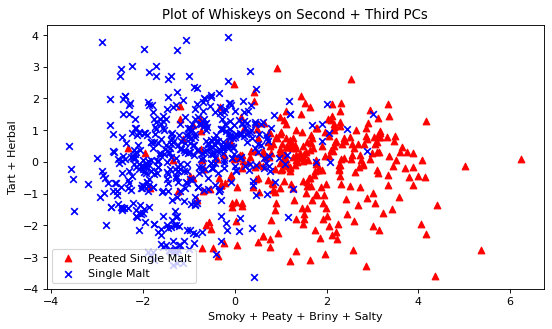

In [30]:
figure(figsize=(7, 4), dpi=80)
for l, c, m in zip(np.unique(df_main['Whisk_Type']), colors, markers):
    plt.scatter(flavors_pca.loc[df_main['Whisk_Type'] == l, 1], 
                flavors_pca.loc[df_main['Whisk_Type'] == l, 2], 
                c=c, label=l, marker=m)
plt.xlabel('Smoky + Peaty + Briny + Salty')
plt.ylabel('Tart + Herbal')
plt.legend(loc='lower left')
plt.tight_layout()
plt.title('Plot of Whiskeys on Second + Third PCs')
plt.show()

<br>

### Which distilleries are similar by their flavor profile? Or different?

Most of us would think clustering on the means. <br>
But let's use PCA to visualize this though. <br>

In [31]:
df_main.loc[[0,100,300,600,700,800]]

,Whisk_Name,Whisk_Type,Distiller,Num_Revs,Cost,Age,ABV,smoky,peaty,spicy,herbal,oily,full_bodied,rich,sweet,briny,salty,vanilla,tart,fruity,floral,Communal_Rating,Distiller_Score,Whisk_Loc,Age_Numer,Age_Grp,classic,middle,nas,new,old,rare,(BOTTLED IN) VIRGINIA,CAMPBELTOWN,HIGHLAND,HIGHLANDS,ISLANDS,ISLAY,LOWLANDS,SKYE,SPEYSIDE,Num_Rev_Log
0,TULLIBARDINE THE MURRAY MARSALA FINISH,Single Malt,TULLIBARDINE,8,3,NAS,46.0,0.0,0.0,15.0,10.0,40.0,35.0,40.0,45.0,0.0,0.0,20.0,20.0,35.0,10.0,4.19,86.0,HIGHLANDS,NaN,nas,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,2.08
100,BALBLAIR 2000 1ST RELEASE,Single Malt,BALBLAIR,27,3,NAS,43.0,30.0,0.0,40.0,20.0,20.0,60.0,60.0,70.0,0.0,30.0,70.0,30.0,70.0,20.0,3.41,89.0,HIGHLANDS,NaN,nas,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,3.30
300,GLENFIDDICH AGE OF DISCOVERY BOURBON CASK 19 YEAR,Single Malt,GLENFIDDICH,122,4,19,40.0,10.0,0.0,25.0,0.0,10.0,70.0,75.0,80.0,0.0,0.0,20.0,0.0,35.0,5.0,4.20,89.0,SPEYSIDE,19.0,middle,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,4.80
600,ARDBEG DARK COVE (2016 COMMITTEE RELEASE),Peated Single Malt,ARDBEG,85,4,NAS,55.0,50.0,30.0,25.0,10.0,20.0,80.0,85.0,70.0,20.0,0.0,40.0,20.0,60.0,0.0,4.53,92.0,ISLAY,NaN,nas,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,4.44
700,BOWMORE TEMPEST 10 YEAR,Peated Single Malt,BOWMORE,102,3,10,55.1,40.0,40.0,70.0,40.0,30.0,50.0,50.0,40.0,30.0,30.0,50.0,30.0,50.0,30.0,3.82,89.0,ISLAY,10.0,new,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,4.62
800,THE GLENLIVET NÀDURRA PEATED WHISKY CASK FINIS...,Peated Single Malt,GLENLIVET,166,4,NAS,61.5,60.0,50.0,40.0,20.0,10.0,50.0,30.0,40.0,0.0,0.0,30.0,20.0,30.0,30.0,3.87,87.0,SPEYSIDE,NaN,nas,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,5.11


Let's just consider the top 15 distillers in our dataset.

In [32]:
distillers_vec = df_main.groupby('Distiller').size().reset_index(name = 'count').sort_values(by = ['count'], ascending = False)
distillers_vec[0:15]

,Distiller,count
75,MACALLAN,31
62,HIGHLAND PARK,29
58,GLENMORANGIE,29
69,LAPHROAIG,28
7,ARDBEG,25
15,BALVENIE,23
51,GLENFIDDICH,23
64,KILCHOMAN,21
21,BOWMORE,21
59,GLENROTHES,20


In [34]:
df_top_distillers = df_flavors.copy()
df_top_distillers['Distiller'] = df_main['Distiller']
df_top_distillers = df_top_distillers[df_top_distillers['Distiller'].isin(distillers_vec['Distiller'][0:15])]
df_top_distillers = df_top_distillers.groupby('Distiller').mean()
np.round(df_top_distillers, 3)

,smoky,peaty,spicy,herbal,oily,full_bodied,rich,sweet,briny,salty,vanilla,tart,fruity,floral
Distiller,,,,,,,,,,,,,,
ARDBEG,1.380,1.428,-0.142,0.105,0.451,-0.166,-0.090,-0.327,1.154,0.906,-0.249,-0.150,-0.395,-0.657
BALVENIE,-0.065,-0.328,0.144,-0.194,-0.230,0.584,0.593,0.455,-0.371,-0.483,0.422,-0.111,0.182,0.265
BENRIACH,0.078,0.090,0.343,0.266,0.343,0.033,0.115,0.066,-0.492,-0.113,0.203,0.328,0.286,-0.069
BOWMORE,0.550,0.597,-0.043,-0.217,-0.243,-0.388,-0.311,-0.343,0.470,0.627,-0.479,-0.061,-0.308,-0.510
BRUICHLADDICH,-0.501,-0.676,-0.025,0.193,0.533,0.344,0.346,0.136,0.490,0.575,0.477,0.531,0.558,0.430
GLENFIDDICH,-0.202,-0.517,0.423,-0.208,-0.308,-0.018,0.390,0.435,-0.502,-0.549,0.754,0.156,0.438,0.495
GLENLIVET,-0.364,-0.600,0.057,-0.555,-0.424,-0.048,-0.078,0.273,-0.588,-0.743,0.140,0.272,0.374,-0.118
GLENMORANGIE,-0.765,-0.728,0.146,-0.092,0.216,0.155,0.255,0.585,-0.506,-0.537,0.463,0.600,0.624,0.878
GLENROTHES,-0.557,-0.714,0.729,0.125,-0.265,0.401,0.577,0.751,-0.325,-0.286,0.756,0.161,0.463,0.289


We follow the same steps as before and plot these distillers on our principal components from before. <br>
**Note the scale.**

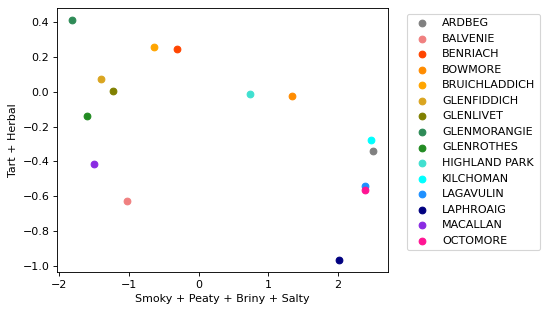

In [36]:
distillers_pca = df_top_distillers @ eig_flavor_mtx

figure(figsize=(7, 4), dpi=80)
# colors = ['r', 'b']
# markers = ['^', 'x']
# for l, c, m in zip(np.unique(df_main['Whisk_Type']), colors, markers):
#     plt.scatter(flavors_pca.loc[df_main['Whisk_Type'] == l, 1], 
#                 flavors_pca.loc[df_main['Whisk_Type'] == l, 2], 
#                 c=c, label=l, marker=m, alpha = 0.1)

colors = ['grey', 'lightcoral', 'orangered', 'darkorange', 'orange', 
          'goldenrod', 'olive', 'seagreen', 'forestgreen', 'turquoise',
         'cyan', 'dodgerblue', 'navy', 'blueviolet', 'deeppink']    
for lbl, c in zip(np.array(distillers_pca.index), colors):
    plt.scatter(distillers_pca.loc[lbl, 1], 
                distillers_pca.loc[lbl, 2], 
                c=c, label=lbl)
plt.xlabel('Smoky + Peaty + Briny + Salty')
plt.ylabel('Tart + Herbal')
# plt.legend(loc='lower left')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.tight_layout()
plt.show()

<br>

### Another way to think about PCA

https://web.stanford.edu/class/cs168/l/l9.pdf <br>
(Note this mentions a slightly different process called SVD. But for our purposes of a covariance matrix, PCA which uses  Eigenvalue Decomposition and Singular Value Decomposition are the same.)

Below is the covariance matrix of the whiskeys dataset. This tells us how the flavors are move with each other.

In [ ]:
cov_mtx_full = np.round(np.cov(df_flavors.T), 3)
print(df_flavors.columns)
print(cov_mtx_full)

Let's say we don't want to store all 15x15 values... What is the most efficient way to store this data without too much loss of info?

Turns out the eigenvalues and eigenvectors do that for us!

In [ ]:
eigenval_list = [eigen_pair[0] for eigen_pair in eigen_pairs]
# print(np.round(eigenval_list[0:5], 3))
# print(np.round(eig_flavor_mtx, 5))

At each commented step, compare and contrast what happens when we include one more Principal Component to estimate our covariance matrix.

In [ ]:
pc_1 = eig_flavor_mtx[:,0].reshape(-1,1)
eval_1 = eigenval_list[0]
pc_2 = eig_flavor_mtx[:,1].reshape(-1,1)
eval_2 = eigenval_list[1]
pc_3 = eig_flavor_mtx[:,2].reshape(-1,1)
eval_3 = eigenval_list[2]
pc_4 = eig_flavor_mtx[:,3].reshape(-1,1)
eval_4 = eigenval_list[3]
pc_5 = eig_flavor_mtx[:,4].reshape(-1,1)
eval_5 = eigenval_list[4]
fake_cov = np.round(eval_1 * pc_1 @ pc_1.T, 3) # (this is also why sometimes people drop the first Principal Component)
#                     eval_2 * pc_2 @ pc_2.T, 3) 
#                     eval_3 * pc_3 @ pc_3.T, 3)
#                     eval_4 * pc_4 @ pc_4.T, 3)
#                     eval_5 * pc_5 @ pc_5.T, 3) 
fake_cov

<br>

### For affordable whiskeys without any peat, is there anything in the flavor profile that differentiates better vs worse tasting whiskeys?

I'm not buying anything more expensive than 100 dollars (unless Matt wants to give me a raise after this presentation). <br>
But I want to pick ones that tend to taste better to the public (Communal Ratings). <br>
Let's see if PCA can help us with this.

In [37]:
stdard = StandardScaler()
robust = RobustScaler()
mms = MinMaxScaler()

cols_to_scale = ['smoky', 'peaty', 'spicy', 'herbal', 'oily', 'full_bodied', \
                 'rich', 'sweet', 'briny', 'salty', 'vanilla', 'tart', 'fruity', 'floral', \
                 'Communal_Rating', 'Distiller_Score', 'Num_Rev_Log']
df_final[cols_to_scale] = stdard.fit_transform(df_final[cols_to_scale])
df_final[['Cost', 'ABV']] = mms.fit_transform(df_final[['Cost', 'ABV']])

In [38]:
df_adam = df_flavors.copy()
df_adam = df_adam[(df_main['Cost'] <= 3) & (df_main['Whisk_Type'] == 'Single Malt') & (df_main['peaty'] == 0)]

ratings_adam = df_main['Communal_Rating'][(df_main['Cost'] <= 3) & (df_main['Whisk_Type'] == 'Single Malt') & (df_main['peaty'] == 0)]
ratings_class = np.array(['Great']*len(df_adam))
ratings_class[ratings_adam < ratings_adam.quantile(0.75)] = 'Good'
ratings_class[ratings_adam < ratings_adam.quantile(0.50)] = 'Bad'
ratings_class[ratings_adam < ratings_adam.quantile(0.10)] = 'Yuck'

stdard = StandardScaler()
df_adam = stdard.fit_transform(df_adam)

Quick look at ratings.

In [39]:
ratings_adam.describe()

count    198.000000
mean       3.552475
std        0.337582
min        2.360000
25%        3.402500
50%        3.600000
75%        3.765000
max        4.260000
Name: Communal_Rating, dtype: float64

In [40]:
corr_mat = np.cov(df_adam.T)
eigen_vals, eigen_vecs = np.linalg.eig(corr_mat)

# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

eig_flavor_adam = np.hstack((eigen_pairs[0][1][:, np.newaxis],
                        eigen_pairs[1][1][:, np.newaxis],
                        eigen_pairs[2][1][:, np.newaxis]))

adam_flavors_pca = df_adam @ eig_flavor_adam

eig_flavor_admdf = pd.DataFrame(np.round(eig_flavor_adam, 3), columns = ['PC1','PC2','PC3'])
eig_flavor_admdf['flavor'] =  ['smoky', 'peaty', 'spicy', 'herbal', 'oily', 'full_bodied', 'rich', 'sweet', 'briny', 'salty', 'vanilla', 'tart', 'fruity', 'floral']
eig_flavor_admdf = eig_flavor_admdf.set_index('flavor')
eig_flavor_admdf.T

flavor,smoky,peaty,spicy,herbal,oily,full_bodied,rich,sweet,briny,salty,vanilla,tart,fruity,floral
PC1,0.249,0.0,0.307,0.245,0.236,0.292,0.300,0.286,0.239,0.295,0.320,0.179,0.334,0.285
PC2,0.051,0.0,0.015,0.347,0.221,-0.415,-0.424,-0.390,0.387,0.265,-0.042,0.291,-0.093,0.095
PC3,-0.297,0.0,0.153,0.035,-0.209,-0.275,-0.201,0.073,-0.363,-0.340,0.303,0.407,0.327,0.332


**PC 1:** "Some of everything" <br>

**PC 2:** "+(Herbal + Briny) and -(Full Body + Rich + Sweet)"

**Do these two PC's do a good job at differentiating generally good vs bad whiskeys?**

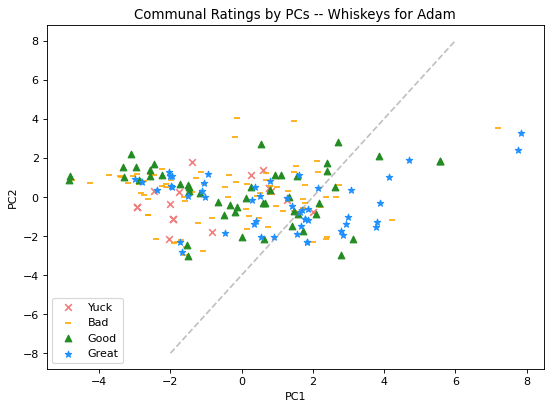

In [45]:
colors = ['lightcoral', 'orange', 'forestgreen', 'dodgerblue']
markers = ['x', '_', '^', '*']

x = [-2, -1, 0, 1, 2, 3, 4, 5, 6]
y = [2*xval - 4 for xval in x]

figure(figsize=(7, 5), dpi=80)
for l, c, m in zip(np.array(['Yuck', 'Bad', 'Good', 'Great']), colors, markers):
    plt.scatter(adam_flavors_pca[ratings_class == l, 0], 
                adam_flavors_pca[ratings_class == l, 1], 
#                 np.zeros((np.sum(ratings_class == l))), 
                c=c, label=l, marker=m)

plt.plot(x, y, '--', c = 'gray', alpha = 0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.title('Communal Ratings by PCs -- Whiskeys for Adam')
plt.show()

<br>

## Linear Discriminant Analysis

### LDA Motivation 

Suppose we want to know whether the flavor profiles of whiskeys do a good job at differentiating the price of scotch. <br>

Let's also include a potentially VERY useful feature in here. <br>
**Namely, Age of Scotch** <br>

We create a new "df_final" dataframe, but this time including the (binned) age groups since we know they should have some predictive power in splitting up scotch prices.

In [46]:
from sklearn.preprocessing import StandardScaler

age_mapper = {'new':1, 'classic':2, 'nas':3, 'middle':4, 'old':5, 'rare':6}
df_final['Age_Grp_Binned'] = df_main['Age_Grp'].replace(age_mapper)

stdard = StandardScaler()

cols_to_stdize = ['smoky', 'peaty', 'spicy', 'herbal', 'oily', 'full_bodied', \
                 'rich', 'sweet', 'briny', 'salty', 'vanilla', 'tart', 'fruity', 'floral', \
                 'Age_Grp_Binned']
df_final[cols_to_stdize] = stdard.fit_transform(df_final[cols_to_stdize])

Recall the age groupings from earlier: <br>

    (df_main['Age_Numer'] < 12) --> new
    (df_main['Age_Numer'] >= 12) & (df_main['Age_Numer'] < 15) --> classic
    (df_main['Age_Numer'] >= 15) & (df_main['Age_Numer'] < 20) --> middle
    (df_main['Age_Numer'] >= 20) & (df_main['Age_Numer'] < 25) --> old
    (df_main['Age_Numer'] >= 25) --> rare
    (np.isnan(df_main['Age_Numer']) --> NAS or nas

In [49]:
df_main.groupby(['Age_Grp']).size().reset_index(name='count')

,Age_Grp,count
0,classic,112
1,middle,147
2,nas,339
3,new,109
4,old,42
5,rare,52


In [50]:
df_main.groupby(['Age_Grp'])['Cost'].apply(lambda x: np.round(np.mean(x), 3)).reset_index(name = 'Average Cost')

,Age_Grp,Average Cost
0,classic,2.946
1,middle,3.864
2,nas,3.260
3,new,3.248
4,old,4.762
5,rare,5.000


We know that the age groupings definitely do a pretty good job of differentiating whiskey cost. <br>

**Is this reflected in PCA?** <br>
If yes, we would be able to draw a straight line through our dataset that separates the groups.

In [51]:
df_flavors_2 = df_final[['smoky', 'peaty', 'spicy', 'herbal', 'oily', 'full_bodied', \
                       'rich', 'sweet', 'briny', 'salty', 'vanilla', 'tart', 'fruity', 'floral', \
                        'Age_Grp_Binned']]

corr_mat = np.cov(df_flavors_2.T)
eigen_vals, eigen_vecs = np.linalg.eig(corr_mat)

eigen_pairs_2 = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

eigen_pairs_2.sort(key=lambda k: k[0], reverse=True)

eig_flavor2_mtx = np.hstack((eigen_pairs_2[0][1][:, np.newaxis],
                        eigen_pairs_2[1][1][:, np.newaxis],
                        eigen_pairs_2[2][1][:, np.newaxis], 
                        eigen_pairs_2[3][1][:, np.newaxis],
                        eigen_pairs_2[4][1][:, np.newaxis]))

flavors_2_pca = df_flavors_2.dot(eig_flavor2_mtx)

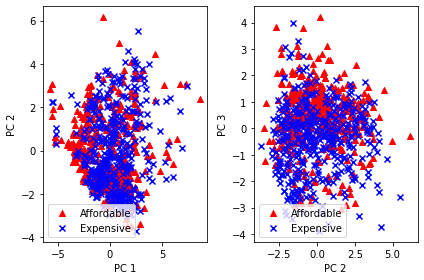

In [52]:
expensivec = np.array(['Affordable']*len(df_final))
expensivec[df_final['Cost'] >= 0.75] = 'Expensive' # 3 STARS

colors = ['r', 'b']
markers = ['^', 'x']

plt.subplot(1, 2, 1)
for lbl, c, m in zip(np.unique(expensivec), colors, markers):
    plt.scatter(flavors_2_pca.loc[expensivec == lbl, 0], 
                flavors_2_pca.loc[expensivec == lbl, 1], 
                c=c, label=lbl, marker=m)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()

plt.subplot(1, 2, 2)
for lbl, c, m in zip(np.unique(expensivec), colors, markers):
    plt.scatter(flavors_2_pca.loc[expensivec == lbl, 1], 
                flavors_2_pca.loc[expensivec == lbl, 2], 
                c=c, label=lbl, marker=m)
plt.xlabel('PC 2')
plt.ylabel('PC 3')
plt.legend(loc='lower left')
plt.tight_layout()
plt.rcParams["figure.figsize"] = (9, 5)
plt.show()

Nope. No differentiation based on the first 3 Principal Components. Why? <br>

**Because PCA is an Unsupervised technique for dimension reduction.** <br>

**Is there an equivalent Supervised technique?**

<br>

### Linear Discriminant Analysis Setup

Linear Discriminatory Analysis (LDA) is a supervised technique in dimension reduction. <br>

Instead of purely trying to identify whiskeys based on how the flavor profiles move together, it instead tries to find the optimal directions of data that do the best at splitting up our target -- **whiskeys by their price**. <br>

How? Think of it as a projection onto another dimension that maximizes the difference between our (price) groups. <br>
https://omarshehata.github.io/lda-explorable/

**Note:** LDA works best for datasets with continuous, normallly distributed variables. <br>

It does not work as well with categorical variables (transformed into one-hots). <br>

(https://maelfabien.github.io/machinelearning/LDA/)

Minor Note: decided to bucket Cost = 1 into Cost = 2 because there are too few oberservations.

In [53]:
print(df_main.groupby('Cost').size().reset_index(name='count'))

df_main['Cost'][df_main['Cost'] == 1] = 2 # ALSO we want the DEEP OR SHALLOW copy? Maybe just shallow is fine
cost_vec = df_main['Cost'].copy() # NO MORE 1. Just 2, 3, 4, 5. 
cost_vec[cost_vec==1] = 2

mean_vecs = []
for label in np.unique(cost_vec):
    mean_vecs.append(np.mean(df_flavors_2[cost_vec == label], axis=0))

len(mean_vecs)

print(df_main.groupby('Cost').size().reset_index(name='count'))

   Cost  count
0     1      9
1     2    123
2     3    276
3     4    231
4     5    162
   Cost  count
0     2    132
1     3    276
2     4    231
3     5    162


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Compute the within-class scatter matrix (scaled by num labels per class). <br>

In [54]:
d = df_flavors_2.shape[1]  # number of features
print(d, "dimensions\n")

S_W = np.zeros((d, d))
for label, mv in zip(np.unique(cost_vec), mean_vecs): # two classes
    print(df_flavors_2[cost_vec == label].shape)
    class_scatter = np.cov(df_flavors_2[cost_vec == label].T)
    S_W += class_scatter
print('Scaled within-class scatter matrix: %sx%s' % (S_W.shape[0],
                                                     S_W.shape[1]))

15 dimensions

(132, 15)
(276, 15)
(231, 15)
(162, 15)
Scaled within-class scatter matrix: 15x15


In [ ]:
# PROBLEM CODE NOT SCALING?

# a = np.cov(df_flavors[cost_vec == label].T)

# class_scatter = np.zeros((d,d))
# for r in range(len(df_flavors[cost_vec == label])):
#     row = np.array(df_flavors.loc[cost_vec == label].iloc[r])
#     row = row.reshape(d,1)
#     mv = np.array(mv).reshape(d, 1)
#     class_scatter += (row - mv).dot((row-mv).T)

# print(len(df_flavors[cost_vec == label]))
# class_scatter/a

Compute the between-class scatter matrix:

In [55]:
mean_overall = np.mean(df_flavors_2, axis=0)

d = df_flavors_2.shape[1]  # number of features
S_B = np.zeros((d, d))
for label, mv in zip(np.unique(cost_vec), mean_vecs): # two classes
    n = df_flavors_2[cost_vec == label].shape[0]
    mv_arr = np.array(mv).reshape(d, 1)  # make column vector
    mean_overall = np.array(mean_overall).reshape(d, 1)  # make column vector
    S_B += n * (mv_arr - mean_overall).dot((mv_arr - mean_overall).T)

print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 15x15


Get the new "linaer discriminant space" below.

In [56]:
new_LDA_space = np.linalg.inv(S_W).dot(S_B)

We see that the new "linear discriminant space" created by taking the proudct of... <br>
*the inverse("within SS") or inv(S_W)* <br> 
*the "between SS" or S_B* <br>

Why is this the case? <br>

**Intuition** <br>

We want to project our whiskeys onto a new space that maximizes the distance between labels. <br>

Suppose two points are in the different groups with means fairly far apart, but each group has a huge within-group variance. <br>
We get benefit by the means being far apart (S_B is big), but inv(S_W) is very small. **Not as much separation.** <br>

Suppose now the points are in the different groups with means fairly far apart, and each group has very tiny within-group variance. <br>
We get benefit by the means being far apart (S_B is big), and inv(S_W) is big. **A lot of separation.** <br>

<br>

### Running PCA on the new Linear Discriminant space

After we project our dataset onto this new LD-space, we can then follow similar steps above to PCA, and see how good the new Principal Components on the Linear Discriminants do in differentiating the cost of whiskeys.

In [57]:
eigen_vals, eigen_vecs = np.linalg.eig(new_LDA_space)

In [58]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in descending order:\n')
for eigen_val in eigen_pairs:
    print(np.round(eigen_val[0], 5))

Eigenvalues in descending order:

122.60482
12.06522
1.81045
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


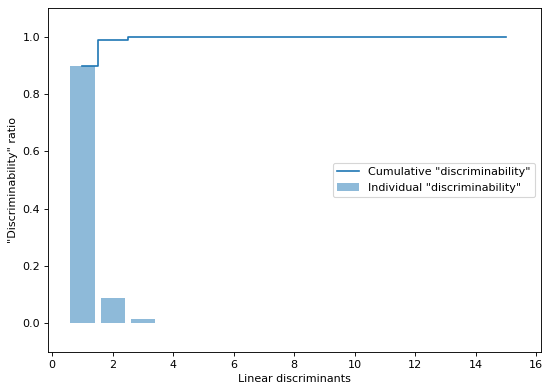

In [59]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

figure(figsize=(7, 5), dpi=80)
plt.bar(range(1, d+1), discr, alpha=0.5, align='center',
        label='Individual "discriminability"')
plt.step(range(1, d+1), cum_discr, where='mid',
         label='Cumulative "discriminability"')
plt.ylabel('"Discriminability" ratio')
plt.xlabel('Linear discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [60]:
LD_mtx = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
                    eigen_pairs[1][1][:, np.newaxis].real, 
                    eigen_pairs[2][1][:, np.newaxis].real))
LD_df = pd.DataFrame(np.round(LD_mtx, 4), columns = ['LD1','LD2','LD3'])
LD_df['cols'] =  ['smoky', 'peaty', 'spicy', 'herbal', 'oily', 'full_bodied', 'rich', 'sweet', 'briny', 'salty', 'vanilla', 'tart', 'fruity', 'floral', 'Age_Grp_Binned']
LD_df = LD_df.set_index('cols')
LD_df

,LD1,LD2,LD3
cols,,,
smoky,0.2392,-0.2005,-0.1618
peaty,0.0101,0.1578,0.1593
spicy,0.0926,-0.2662,-0.1712
herbal,-0.0811,0.1166,0.2784
oily,0.0874,-0.2837,-0.2601
full_bodied,0.1609,-0.3828,0.1482
rich,0.3591,0.1638,0.0438
sweet,-0.2237,0.3620,-0.2673
briny,0.1210,-0.1696,-0.4841


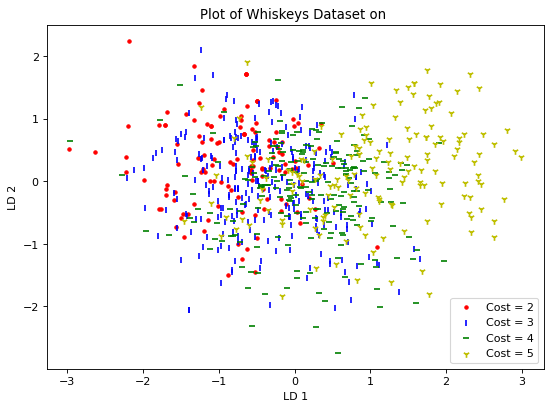

In [63]:
X_train_lda = df_flavors_2.dot(LD_mtx)
colors = ['r', 'b', 'g', 'y']
markers = ['.', '|', '_', '1']

figure(figsize=(7, 5), dpi=80)
for l, c, m in zip(np.unique(cost_vec), colors, markers):
    plt.scatter(X_train_lda.loc[cost_vec == l, 0],
                X_train_lda.loc[cost_vec == l, 1],
#                 np.zeros(len(X_train_lda.loc[cost_vec == l, 1])),
                c=c, label=l, marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(['Cost = 2', 'Cost = 3', 'Cost = 4', 'Cost = 5'], loc='lower right')
plt.tight_layout()
plt.title('Plot of Whiskeys Dataset on ')
plt.show()

<br>
<br>

## Kernel PCA Exploration

Suppose dataset looked slightly different, less features. Peaty/Smoky, Fruity/Sweet, Spicy. <br>

Let's assume that people just like whiskeys that have a lot of flavor, and ones that are sort of flavorless throughout are not great. <br>
How would this look? <br>
(x,y,z)=(ρcosθsinϕ,ρsinθsinϕ,ρcosϕ) <br>
https://socratic.org/questions/what-is-the-parametric-equation-of-a-sphere

In [ ]:
rho = 5
sims = 1000

rho_sim = np.random.normal(loc=rho, scale=0.2, size=sims*3).reshape(3, -1)
theta_sim = np.random.uniform(0, 2*np.pi, size = sims)
phi_sim = np.random.uniform(0, np.pi, size = sims)
x_sim1 = rho_sim[0,]*np.cos(theta_sim)*np.sin(phi_sim) # Peaty/Smoky
y_sim1 = rho_sim[1,]*np.sin(theta_sim)*np.sin(phi_sim) # Fruity/Sweet
z_sim1 = rho_sim[2,]*np.cos(phi_sim) # Spicy

plt.scatter(x_sim1, y_sim1, color='red', marker='^', alpha=0.5)
plt.title('Projection of Expensive Whiskeys onto Spicy = 0 Plane')
plt.xlabel('Peaty/Smoky')
plt.ylabel('Fruity/Sweet')
plt.show()

In [ ]:
rho = 1
sims = 1000

rho_sim = np.random.normal(loc=rho, scale=0.4, size=sims*3).reshape(3, -1)
theta_sim = np.random.uniform(0, 2*np.pi, size = sims)
phi_sim = np.random.uniform(0, np.pi, size = sims)
x_sim2 = rho_sim[0,]*np.cos(theta_sim)*np.sin(phi_sim) # Peaty/Smoky
y_sim2 = rho_sim[1,]*np.sin(theta_sim)*np.sin(phi_sim) # Fruity/Sweet
z_sim2 = rho_sim[2,]*np.cos(phi_sim) # Spicy

plt.scatter(x_sim2, y_sim2, color='blue', marker='o', alpha=0.5)
plt.title('Projection of Cheap Whiskeys onto Spicy = 0 Plane')
plt.xlabel('Peaty/Smoky')
plt.ylabel('Fruity/Sweet')
plt.show()

In [ ]:
plt.scatter(x_sim1[np.abs(z_sim1)<0.3], y_sim1[np.abs(z_sim1)<0.3], color='red', label='Expensive', marker='^', alpha=0.5)
plt.scatter(x_sim2[np.abs(z_sim2)<0.3], y_sim2[np.abs(z_sim2)<0.3], color='blue', label='Cheap', marker='o', alpha=0.5)
plt.title('Expensive and Cheap Whiskeys onto Spicy = 0 Plane')
plt.xlabel('Peaty/Smoky')
plt.ylabel('Fruity/Sweet')
plt.legend(loc='lower left')
plt.show()

Now we use KPCA to see if we can different the two groups.

In [ ]:
X_sim_exp = np.hstack((x_sim1.reshape(1000, 1), y_sim1.reshape(1000, 1), z_sim1.reshape(1000, 1)))
X_sim_cheap = np.hstack((x_sim2.reshape(1000, 1), y_sim2.reshape(1000, 1), z_sim2.reshape(1000, 1)))
X_sim = np.vstack((X_sim_exp, X_sim_cheap))

fake_cost = ['Expensive']*X_sim_exp.shape[0]
fake_cost.extend(['Cheap']*X_sim_cheap.shape[0])
fake_cost = np.array(fake_cost)

### Intuition behind KPCA

It essentially calcualtes a distance matrix of all points to one another, but based on a way we define.

In [ ]:
from scipy.spatial.distance import pdist, squareform
from numpy import exp
from scipy.linalg import eigh
import numpy as np

dist_mtx = pdist(X_sim, 'sqeuclidean')
dist_mtx = squareform(dist_mtx)
print(np.round(dist_mtx[1,[0, 5, 10, 500, 510, 1005, 1020, 1500, 1560]], 2))
print(np.round(dist_mtx[501,[0, 5, 10, 500, 510, 1005, 1020, 1500, 1560]], 2))
print(np.round(dist_mtx[1001,[0, 5, 10, 500, 510, 1005, 1020, 1500, 1560]], 2))
print(np.round(dist_mtx[1501,[0, 5, 10, 500, 510, 1005, 1020, 1500, 1560]], 2))
print(np.round(dist_mtx[[0, 5, 10, 500, 510, 1005, 1020, 1500, 1560],1501], 2))

In [ ]:
gamma = 3
dist_ktx = exp(-gamma * dist_mtx)
print(np.round(dist_ktx[1,[0, 5, 10, 500, 510, 1005, 1020, 1500, 1560]], 4))
print(np.round(dist_ktx[501,[0, 5, 10, 500, 510, 1005, 1020, 1500, 1560]], 4))
print(np.round(dist_ktx[1001,[0, 5, 10, 500, 510, 1005, 1020, 1500, 1560]], 4))
print(np.round(dist_ktx[1501,[0, 5, 10, 500, 510, 1005, 1020, 1500, 1560]], 4))
print(np.round(dist_ktx[[0, 5, 10, 500, 510, 1005, 1020, 1500, 1560],1501], 4))

<br>

### Running KPCA with radial basis function

**Distance between two points is based on how "far" they are relative to the normal distribution.** <br>

Gamma essenitally jsut represents the inverse variance of the normal distribution we use to calculate the distance.

In [ ]:
from scipy.spatial.distance import pdist, squareform
from numpy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation.

    Parameters
    ------------
    X: {NumPy ndarray}, shape = [n_examples, n_features]
        
    gamma: float
      Tuning parameter of the RBF kernel
        
    n_components: int
      Number of principal components to return

    Returns
    ------------
     X_pc: {NumPy ndarray}, shape = [n_examples, k_features]
       Projected dataset   

    """
    # Calculate pairwise squared Euclidean distances
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean')

    # Convert pairwise distances into a square matrix.
    mat_sq_dists = squareform(sq_dists)

    # Compute the symmetric kernel matrix.
    K = exp(-gamma * mat_sq_dists)

    # Center the kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Obtaining eigenpairs from the centered kernel matrix
    # scipy.linalg.eigh returns them in ascending order
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    # Collect the top k eigenvectors (projected examples)
    X_pc = np.column_stack([eigvecs[:, i]
                            for i in range(n_components)])

    # Collect the top k eigenvectors (projected examples)
    alphas = np.column_stack([eigvecs[:, i]
                              for i in range(n_components)])

    # Collect the corresponding eigenvalues
    lambdas = [eigvals[i] for i in range(n_components)]

    return X_pc, alphas, lambdas

Changing gamma, the variance of our distance function, has a significant effect on the separability in our PCA plots below.

In [ ]:
X_kpca, alphas, lambdas = rbf_kernel_pca(X_sim, gamma=2, n_components=3)

plt.scatter(X_kpca[fake_cost=='Cheap', 0], X_kpca[fake_cost=='Cheap', 1], 
            color='red', marker='^', label = 'Cheap', alpha=0.5)
plt.scatter(X_kpca[fake_cost=='Expensive', 0], X_kpca[fake_cost=='Expensive', 1],
            color='blue', marker='o', label = 'Expensive', alpha=0.5)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.title('PCA plot of the kernel distance matrix. Small gamma = 2')
plt.show()

In [ ]:
X_kpca2, alphas2, lambdas2 = rbf_kernel_pca(X_sim, gamma=8, n_components=3)

plt.scatter(X_kpca2[fake_cost=='Cheap', 0], X_kpca2[fake_cost=='Cheap', 1], 
            color='red', marker='^', label = 'Cheap', alpha=0.5)
plt.scatter(X_kpca2[fake_cost=='Expensive', 0], X_kpca2[fake_cost=='Expensive', 1],
            color='blue', marker='o', label = 'Expensive', alpha=0.5)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.title('PCA plot of the kernel distance matrix. Gamma = 8')
plt.show()

<br>

### Projecting a new point onto our kernel distance matrix.  And then plotting onto our PCA plot of the matrix.

Suppose we have a new whisky comg in. Lots of flavor all around. <br>
Fairly Peaty/Smoky, Very Fruity/Sweet, Fairly Spicy. <br>

Polar coordinates representation: rho = 5, theta = pi/3, phi = pi/3

In [ ]:
x_new = np.array([2.15, 4, 2.5])

In [ ]:
def project_x(x_new, X, gamma, alphas, lambdas):
    pair_dist = np.array([np.sum((x_new - row)**2) for row in X])
    k = np.exp(-gamma * pair_dist)
    return k.dot(alphas / lambdas)

# projection of the new whiskey
x_proj = project_x(x_new, X_sim, gamma=2, alphas=alphas, lambdas=lambdas)
x_proj

In [ ]:
plt.scatter(X_kpca[fake_cost=='Cheap', 0], X_kpca[fake_cost=='Cheap', 1], 
            color='red', marker='^', label = 'Cheap', alpha=0.5)
plt.scatter(X_kpca[fake_cost=='Expensive', 0], X_kpca[fake_cost=='Expensive', 1],
            color='blue', marker='o', label = 'Expensive', alpha=0.5)
plt.scatter(x_proj[0], x_proj[1], color='black',
            label='New Whiskey that arrived', marker='x', s=100)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [ ]:
# Sum of outer products --> covariance matrix
# Which locations might be most similar by flavor profile? LDA? Or cluster mean? 
# Break out by Single Malt vs Single Malt Peated? See if any nuances in taste correlate with rating/score.
# Why does Whiskey location matter? Why does age matter? And whiskey type? 